### Look at dependancies 

In [108]:
import numpy
import matplotlib.pyplot as plt
import pandas
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from keras_tqdm import TQDMNotebookCallback


# fix random seed for reproducibility
numpy.random.seed(7)

DATA_DIR = 'historical_data'
FILE_NAME = "USDT_BTC.csv"

# load the dataset
dataframe = pandas.read_csv(DATA_DIR+"/"+FILE_NAME)

interval = dataframe['date'][1]-dataframe['date'][0] #interval in seconds
interval = interval/60 
#print(interval)

del dataframe['quoteVolume']
del dataframe['date']


In [61]:
col_names = dataframe.columns.values
print(col_names)

full_dataset = dataframe.values
full_dataset = full_dataset.astype('float32')

#pick out last column
dataset = np.ones([full_dataset.shape[0],1])
dataset[:,0] = full_dataset[:,5]

#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

['close' 'high' 'low' 'open' 'volume' 'weightedAverage']
149014 73396


In [204]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_foward=1):
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_foward-1):
        x = dataset[i:(i+look_back), 0]
        dataX.append(x)
        y = dataset[(i+look_back):(i+look_back+look_foward),0]
        dataY.append(y)
    return numpy.array(dataX), numpy.array(dataY)

look_back = 50
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [205]:

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_19 (LSTM)                   (None, 50)            20200       lstm_input_19[0][0]              
____________________________________________________________________________________________________
dense_19 (Dense)                 (None, 1)             51          lstm_19[0][0]                    
Total params: 20251
____________________________________________________________________________________________________


In [ ]:
model.fit(trainX, trainY, nb_epoch=50, batch_size=1000, verbose=0, callbacks=[TQDMNotebookCallback()])

In [163]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [164]:
# calculate root mean squared error at different levels of extrapolation and print results

print('           ', end='')
for i in range(look_forward):
    print('%4i  ' % (i+1), end='')

print('\nTrain RMSE: ', end='')
for i in range(look_forward):
    trainScore += np.sqrt(mean_squared_error(trainY[:,i], trainPredict[:,i]))
    print('%.1f ' % (trainScore), end='')
    
print('\nTest  RMSE: ', end='')    
for i in range(look_forward):
    testScore += np.sqrt(mean_squared_error(testY[:,i], testPredict[:,i]))
    print('%.1f ' % (trainScore), end='')



              1     2     3     4     5     6     7     8     9    10  
Train RMSE: 407.1 414.1 420.3 427.3 434.3 441.0 447.8 454.7 461.6 468.2 
Test  RMSE: 468.2 468.2 468.2 468.2 468.2 468.2 468.2 468.2 468.2 468.2 

In [ ]:
print(train)

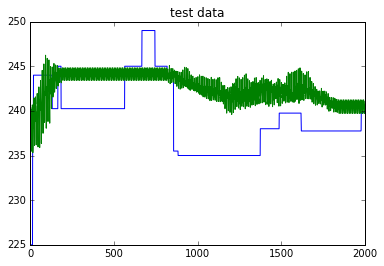

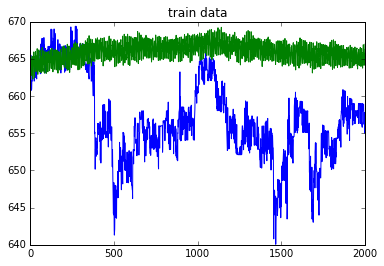

In [203]:
%matplotlib inline

def make_plot(dataX, predY, title=''):
    # shift train predictions for plotting
    min2plt = 0
    max2plt = 2000
    rng = max2plt - min2plt
    lf = look_foward
    num2plt = int(rng/lf)

    data2plt = scaler.inverse_transform(dataX[:,0,:])[min2plt:max2plt,0]
    allpreds = predY[min2plt:max2plt,:]

    pred2plt = np.zeros_like(data2plt)
    for i in range(num2plt):
        pred2plt[i*lf:(i+1)*lf] = allpreds[i,:]

    #plot baseline and predictions
    plt.plot()
    plt.plot(data2plt)
    plt.plot(pred2plt)
    plt.title(title)
    plt.show()

make_plot(trainX, trainPredict, title='test data')
make_plot(testX,  testPredict,  title='train data')
